![DataScienceSeed Logo](http://www.datascienceseed.com/wp-content/uploads/2018/02/dsst.jpg)
## Dataset Hands-On Challenge 
Marcello's working notebook on the [Flairbit](http://www.flairb.it/) Challenge presented on the February 7 2019 event:

http://www.datascienceseed.com/2019/02/10/dataset-challenge-hands-on-1-flairbit-coffee-machines-rulex-churn-service/

Dataset details and download instructions are at the link above, in the Flairbit section of the event.

## The dataset
* Data related to professional coffe machines
* Dataset categories:
    * Counters
    * Cleanings
    * Faults
* One file per category per day
    *type_YYYYMMDDHHMMSS-an.csv (e.g., faults_20190103020001-an.csv)
* Common dataset feature
    * Machine serial number
    * Machine model
    * Timestamp (YYYY MM DD hh:mm:ss and week number)



**counters**

Serial | YYYY | MM | dd | hh:mm:ss | Week | Model | LabelCounter | AbsoluteCounter | RelativeCounter
-------|------|----|----|----------|------|-------|--------------|-----------------|----------------
1535632 | 2016 | 11 | 29 | 04:00:07 | 49 | model 31 | numcaffegenerale | 179112 | 0
1535632 | 2016 | 11 | 29 | 05:00:07 | 49 | model 31 | numcaffegenerale | 179120 | 8
1535632 | 2016 | 11 | 29 | 06:00:07 | 49 | model 31 | numcaffegenerale | 179158 | 38

**cleanings**

Serial | YYYY | MM | dd | hh:mm:ss | Week | Model | Errorcode 
-------|------|----|----|----------|------|-------|-----------
1535632 | 2016 | 11 | 29 | 04:00:07 | 49 | model 10 | 1
1535632 | 2016 | 11 | 29 | 05:00:07 | 49 | model 9 | 1 
1535632 | 2016 | 11 | 29 | 06:00:07 | 49 | model 31 |1 

**faults**

Serial | YYYY | MM | dd | hh:mm:ss | Week | Model | Errorcode | Critical 
-------|------|----|----|----------|------|-------|-----------|------------
1535632 | 2016 | 11 | 29 | 04:00:07 | 49 | model 62 | 185 | WARNING
1535632 | 2016 | 11 | 29 | 05:00:07 | 49 | model 20| 185 | WARNING
1535632 | 2016 | 11 | 29 | 06:00:07 | 49 | model 20 |185 | WARNING

### Warm up: Let’s query the CSV files
* How many connected machines?
* Counters types
* Faults distribution per model
* Cleanings misses distribution per model

## Challenges:

### Forecasting
* Predict faults occurrences based on counters patterns and cleaning misses

### Root cause analysis
* Find correlations between machine usage (counters and cleanings misses) and faults

## Credits
Thanks to [Flairbit](http://www.flairb.it/) for providing this dataset to the [DataScienceSeed](http://www.datascienceseed.com/) community! **This notebook has no commercial purpose** it is provided for educational purposes alone.
![Flairbit](https://www.alleantia.com/wp-content/uploads/2013/11/FlairBit.png)

https://github.com/mallibus/Flairbit-Coffee-Machines-DataWranglin

**Folder structure** 

This notebook is expected to be executed inside a folder at the same level of ```operational-data```, root folder of the dataset. The datset files are reached as `../operational-data/cleanings/*.csv`,`../operational-data/counters/*.csv`, `../operational-data/faults/*.csv`.

Please keep in the same folder of the notebook the small script ```progress.py```: it just implements a simple progress bar to avoid half an hour of staring at nothing while datset loads.




In [1]:
# Change this if the dataset is elsewhere
dataset_root = "../operational-data/"


# Let's prepare the scene

In [1]:
# Import some useful libraries (they are supposed to be installed in your python environment)

# Pandas is the workhorse of data analytics libraries in Python - 90% of your data wrangling will be in Pandas
import pandas as pd
# Numpy is the array machine - you just need it, soon or late
import numpy as np
# The following lines tell to Pandas that when it shows a data frame:
# I want to see up to 999 columns 
pd.options.display.max_columns = 999
# I want to see up to 20 rows
pd.options.display.max_rows = 30

# Matplotlib is the main data visualization libray in Python 
import matplotlib.pyplot as plt
# You need the following ugly stuff to access to the filesystem from Python
import sys, os, fnmatch
# And this is used for dates management
import datetime as dt

# The spell below tells to Jupyter Notebook that you want pictures in the cells
%matplotlib inline

In [2]:
# Import simple status bar from the file progress.py which is the the same folder of this notebook
from progress import progress


In [3]:
def load_files(folder=".",pattern="*.csv",how_many_files = -1):
    """ Utility function to load all the files of the a dataset category
    folder = relative path of the dataset files
    pattern = pattern to identify dataset files
    how_many_files = number of files to load. -1 stands for "ALL"
    """
    try:
        files = fnmatch.filter(os.listdir(folder),pattern)
    except:
        print("Problems in listing files inside folder:"+folder)
        print("No data loaded")
        return

    if how_many_files<=0:
        how_many_files = len(files)

    print("%s : loading %d files"%(folder,how_many_files))
    
    df = pd.DataFrame()
    for i,f in enumerate(files[:how_many_files]):
        progress(i, how_many_files-1, status='Loading files')
        df = pd.concat([df, pd.read_csv(folder+'/'+f,sep=";")])
        
    print('')
    return df

## Load the dataset

Loading all the files takes 20+ minutes on my PC. To run quick tests you can change `how_many_files` variable. Setit to -1 to load all files

In [5]:
how_many_files=-1 # -1 stands for ALL

In [6]:
# Let's take note of what time is it when start loading files... it will take a while
start = dt.datetime.now()

# Start with the big hog of counters... be patient
df_counters = load_files(folder=dataset_root+"counters",how_many_files=how_many_files)

../operational-data/counters : loading 395 files
[============================================================] 100.0% ...Loading files


In [7]:
# cleanings and faults are much faster
df_cleanings = load_files(folder=dataset_root+"cleanings",how_many_files=how_many_files)
df_faults = load_files(folder=dataset_root+"faults",how_many_files=how_many_files)
print((dt.datetime.now()-start))

../operational-data/cleanings : loading 391 files
[============================================================] 100.0% ...Loading files
../operational-data/faults : loading 395 files
[============================================================] 100.0% ...Loading files
0:20:48.688782


In [8]:
df_counters.to_pickle("counters.pkl")
df_cleanings.to_pickle("cleanings.pkl")
df_faults.to_pickle("faults.pkl")


In [4]:
start = dt.datetime.now()
df_counters = pd.read_pickle("counters.pkl")
df_cleanings = pd.read_pickle("cleanings.pkl")
df_faults = pd.read_pickle("faults.pkl")
print((dt.datetime.now()-start))

0:00:09.853047


## Let's see the data in its face!

In [5]:
df_counters.head()

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,LabelCounter,AbsoluteCounter,RelativeCounter
0,1535632,2016,11,29,00:00:38,49,model 31,numcaffegenerale,179112.0,0.0
1,1535632,2016,11,29,01:00:07,49,model 31,numcaffegenerale,179112.0,0.0
2,1535632,2016,11,29,02:00:07,49,model 31,numcaffegenerale,179112.0,0.0
3,1535632,2016,11,29,03:00:07,49,model 31,numcaffegenerale,179112.0,0.0
4,1535632,2016,11,29,04:00:07,49,model 31,numcaffegenerale,179112.0,0.0


In [6]:
df_counters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45330415 entries, 0 to 192929
Data columns (total 10 columns):
Serial             int64
YYYY               int64
MM                 int64
dd                 int64
hh:mm:ss           object
Week               int64
Model              object
LabelCounter       object
AbsoluteCounter    float64
RelativeCounter    float64
dtypes: float64(2), int64(5), object(3)
memory usage: 3.7+ GB


## Rearrange data types 

Convert the YYYY MM dd date format into a [pandas Timestamp type](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html) to be used as index in time series

In [7]:
def get_timestamps(df):
    """Utility function returning a Timestamp column built by merging the YYYY,MM,dd,hh:mm:ss columns. 
    First convert into strings the numeric values, then build a string like "YYYY-MM-dd hh:mm:ss" which can be converted into a pd.Timestamp just casting the string to it.
    """
    return (df['YYYY'].astype(str)+'-'+df['MM'].astype(str)+'-'+df['dd'].astype(str)+' '+df['hh:mm:ss']).apply(lambda s: pd.Timestamp(s))

# This will take a while...
start = dt.datetime.now()
df_counters['Timestamp']=get_timestamps(df_counters)
df_cleanings['Timestamp']=get_timestamps(df_cleanings)
df_faults['Timestamp']=get_timestamps(df_faults)
print((dt.datetime.now()-start))

0:03:17.016921



Serial is a numeric value, but I prefer to have strings as keys

In [8]:
df_counters['Serial'] = df_counters['Serial'].astype(str)
df_faults['Serial'] = df_faults['Serial'].astype(str)
df_cleanings['Serial'] = df_cleanings['Serial'].astype(str)


In [9]:
df_counters.head()

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,LabelCounter,AbsoluteCounter,RelativeCounter,Timestamp
0,1535632,2016,11,29,00:00:38,49,model 31,numcaffegenerale,179112.0,0.0,2016-11-29 00:00:38
1,1535632,2016,11,29,01:00:07,49,model 31,numcaffegenerale,179112.0,0.0,2016-11-29 01:00:07
2,1535632,2016,11,29,02:00:07,49,model 31,numcaffegenerale,179112.0,0.0,2016-11-29 02:00:07
3,1535632,2016,11,29,03:00:07,49,model 31,numcaffegenerale,179112.0,0.0,2016-11-29 03:00:07
4,1535632,2016,11,29,04:00:07,49,model 31,numcaffegenerale,179112.0,0.0,2016-11-29 04:00:07


In [10]:
df_counters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45330415 entries, 0 to 192929
Data columns (total 11 columns):
Serial             object
YYYY               int64
MM                 int64
dd                 int64
hh:mm:ss           object
Week               int64
Model              object
LabelCounter       object
AbsoluteCounter    float64
RelativeCounter    float64
Timestamp          datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 4.1+ GB


## Explore counters

What is the most used counter, i.e. the counter used in the majority of machines. 

In [11]:
df_counters[['Model','LabelCounter']].drop_duplicates()\
                .groupby('LabelCounter')['Model'].count().sort_values(ascending=False)

LabelCounter
numcaffegr1         78
numcaffegenerale    77
numacqua            75
nummac1gr1          50
nummac2gr1          50
numcicligr1         50
numlattegr1         48
numvaporeariats     41
numvapore           38
numlattefr          36
numcaffegr2         32
numvaporets         31
ngr2                25
ngr1                25
tempogr2            25
                    ..
numcaffegr3         19
ngr3                17
portatagr3          17
tempogr3            16
nummac3gr1           8
numcaffegr4          4
numsolubile          4
portatagr4           3
ngr4                 3
tempogr4             3
numcicligr2          2
nummac3gr2           2
numlattegr2          2
nummac1gr2           2
nummac2gr2           2
Name: Model, Length: 34, dtype: int64

Counter names are not homogenous - numcaffegr1 is maybe the same as ngr1. 
<font color=blue>**This shall be cleaned with domain competence**</font>

In [12]:
most_used_counter = df_counters[['Model','LabelCounter']].drop_duplicates()\
                .groupby('LabelCounter')['Model'].count().idxmax()
print("The most common counter is ",most_used_counter)

The most common counter is  numcaffegr1


We can use describe to see the distribution of numbers in the counters

In [13]:
mask = df_counters['LabelCounter']==most_used_counter
df_counters[mask][['RelativeCounter']].describe()

,RelativeCounter
count,4.062609e+06
mean,4.301778e+01
std,1.346052e+03
min,-2.003300e+04
25%,0.000000e+00
50%,0.000000e+00
75%,4.000000e+00
max,9.594000e+04


The overall interval is absurdly wide - there are some absurdly big numbers both positive and negative

With an histogram plot to see the distribution in a grphical way

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BC025A5898>]],
      dtype=object)

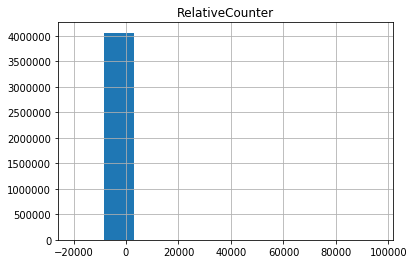

In [14]:
df_counters[mask][['RelativeCounter']].hist()

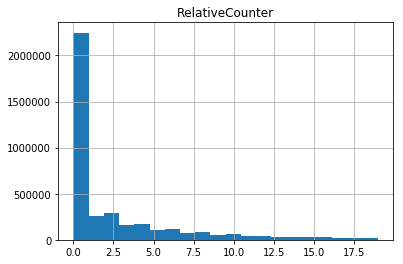

In [15]:
m1 = df_counters['LabelCounter']==most_used_counter
m2 = df_counters['RelativeCounter']>=0
m3 = df_counters['RelativeCounter']<20
df_counters[m1&m2&m3][['RelativeCounter']].hist(bins=20)
plt.show()

the absolute majority of relative counters increments is 0. Those are useless records in nightly times when nothing is happening. They are most likely duplicated rows of same absolute counter same day.

In [16]:
df_counters.duplicated(['Serial', 'YYYY', 'MM', 'dd', 'Week', 'Model','LabelCounter', 'AbsoluteCounter']).sum()

31195146

There are an awful lot of duplicated rows. Let's get rid of them, this will also save some memory

In [17]:
df_counters = df_counters.drop_duplicates(['Serial', 'YYYY', 'MM', 'dd', 'Week', 'Model',
       'LabelCounter', 'AbsoluteCounter'],keep='first')

In [18]:
df_counters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14135269 entries, 0 to 192929
Data columns (total 11 columns):
Serial             object
YYYY               int64
MM                 int64
dd                 int64
hh:mm:ss           object
Week               int64
Model              object
LabelCounter       object
AbsoluteCounter    float64
RelativeCounter    float64
Timestamp          datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 1.3+ GB


Memory usage is much less now. It was 3.7GB, and the distribution now is more interesting

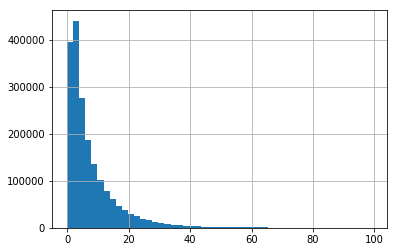

In [19]:
m1 = df_counters['LabelCounter']==most_used_counter
m2 = df_counters['RelativeCounter']>=0
m3 = df_counters['RelativeCounter']<100
df_counters[m1&m2&m3]['RelativeCounter'].hist(bins=50)

another way to see a distribution is a boxplot.

Questions on boxplots? look [here](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

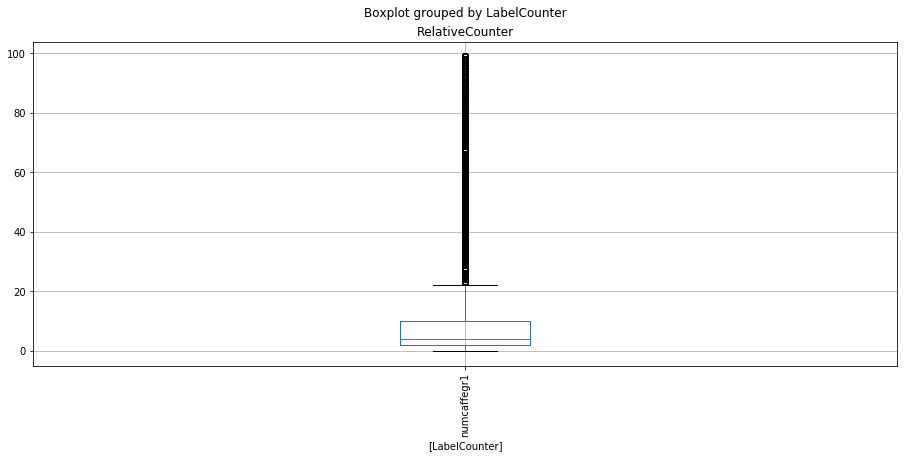

In [20]:
df_counters[m1&m2&m3][['LabelCounter','RelativeCounter']].boxplot(by='LabelCounter',figsize=(15,6))
plt.xticks(rotation=90)
plt.show()

The advantage is that we can look to a number of distributions in the same plot, but again we have to make some cleanup

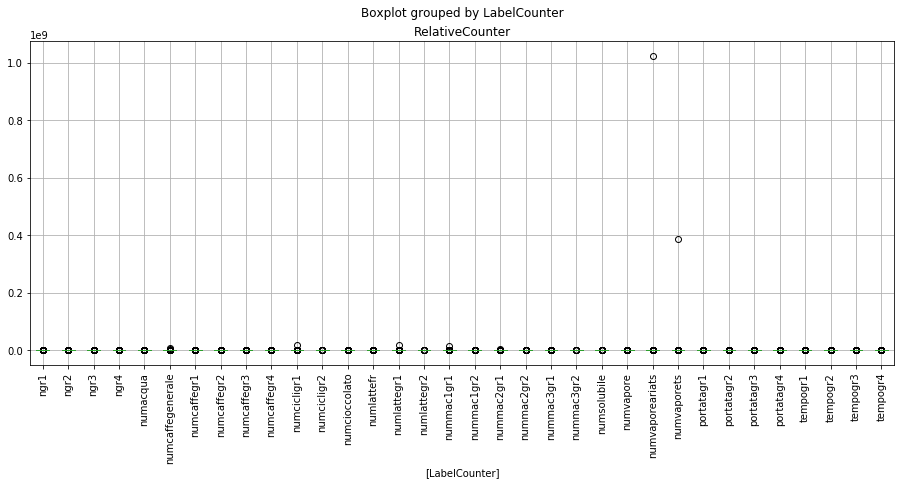

In [21]:
df_counters[['LabelCounter','RelativeCounter']].boxplot(by='LabelCounter',figsize=(15,6))
plt.xticks(rotation=90)
plt.show()

I'll trash all the records which are beyond 3 standard deviations from the average value

In [22]:
max_sigma = 3
intervals = df_counters.groupby('LabelCounter')['RelativeCounter'].agg(['min','max','mean','std'])
filter_max = (intervals['mean']+max_sigma*intervals['mean']).to_dict()

In [23]:
intervals.head()

,min,max,mean,std
LabelCounter,,,,
ngr1,-1000.0,1000.0,3.587506,43.847966
ngr2,-1000.0,1000.0,5.560970,53.560838
ngr3,-1000.0,1000.0,6.144483,61.055212
ngr4,-999.0,80.0,3.834843,46.784952
numacqua,-3574.0,36903.0,6.216437,146.656073


In [24]:
df_counters['check_max']=df_counters['LabelCounter'].map(filter_max)

In [25]:
(df_counters['RelativeCounter']>df_counters['check_max']).sum()

114730

In [26]:
df_counters = df_counters[(df_counters['RelativeCounter']<df_counters['check_max'])&\
                          (df_counters['RelativeCounter']>=0)]

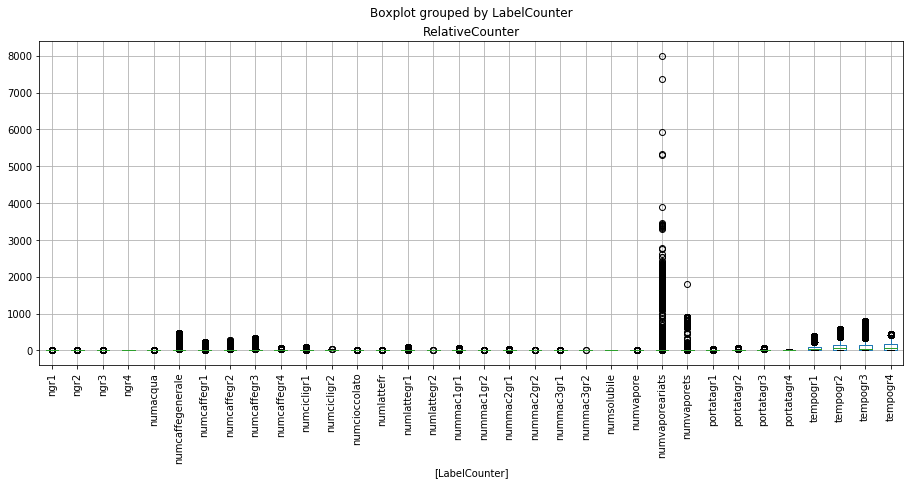

In [27]:
df_counters[['LabelCounter','RelativeCounter']].boxplot(by='LabelCounter',figsize=(15,6))
plt.xticks(rotation=90)
plt.show()

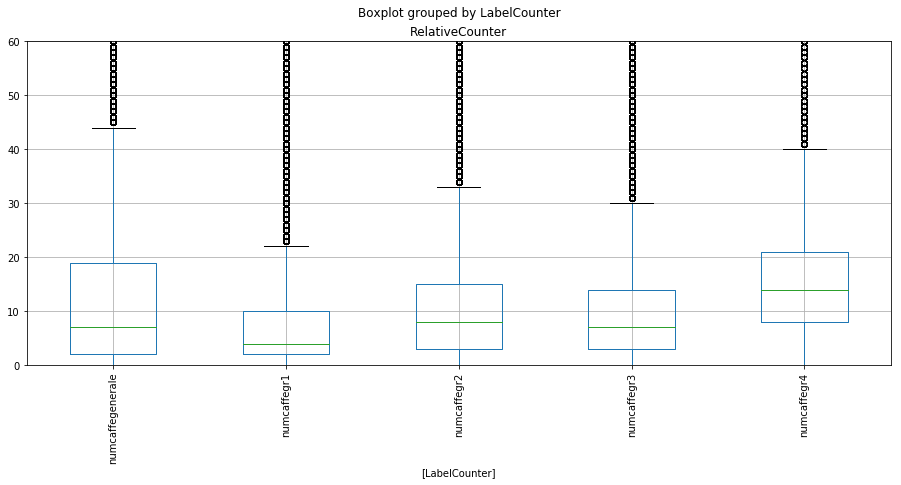

In [28]:
df_counters[(df_counters['LabelCounter'].apply(lambda s:'numcaffe' in s))]\
           [['LabelCounter','RelativeCounter']].boxplot(by='LabelCounter',figsize=(15,6))
plt.ylim((0,60))
plt.xticks(rotation=90)
plt.show()


<font color=blue>**We could do a lot of data cleaning here but we need more domain understanding!**</font>

- what is the right interval for each counter?
- what to do with machines which are giving outliers counters: remove all the history or remove just the records?

## Explore machines population

Let's see how many different machines we have in the datasets

In [29]:
set_counters   = set(df_counters['Serial'].unique())
set_faults     = set(df_faults['Serial'].unique())
set_cleanings  = set(df_cleanings['Serial'].unique())
print("SN in counters  : %5d"%len(set_counters))
print("SN in faults    : %5d"%len(set_faults))
print("SN in cleanings : %5d"%len(set_cleanings))


SN in counters  :  1258
SN in faults    :  1109
SN in cleanings :   718


In [30]:
print("SN in cleaning & faults : %5d"%len(set_cleanings & set_faults))
print("SN in counters & faults : %5d"%len(set_counters & set_faults))
print("SN in all sets          : %5d"%len(set_cleanings & set_counters & set_faults))


SN in cleaning & faults :   688
SN in counters & faults :  1102
SN in all sets          :   684



<font color=blue>**What machines to keep in the dataset to build the model?**</font>

We are interested in the correlation with cleanings and faults so we may decide to keep only the intersection


**How many models and how many serial numbers per model?**

Let's build the series with the number of machines per model, it will be useful later

In [31]:
models_population = pd.concat([df_counters[['Model','Serial']],
                               df_faults[['Model','Serial']], 
                               df_cleanings[['Model','Serial']]]).drop_duplicates()['Model'].value_counts()
models_population

model 20    263
model 10    183
model 13    168
model 9     150
model 11     47
model 12     41
model 8      41
model 60     40
model 63     36
model 50     21
model 14     20
model 31     17
model 5      15
model 19     15
model 22     14
           ... 
model 68      1
model 69      1
model 30      1
model 45      1
model 43      1
model 28      1
model 29      1
model 4       1
model 58      1
model 46      1
model 75      1
model 36      1
model 65      1
model 49      1
model 67      1
Name: Model, Length: 78, dtype: int64

We can notice some bad model code... fortunately it is only one serial. Also we see a lot of models with a single record.


## Explore the faults dataset

In [32]:
df_faults.head()

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,ErrorCode,Critical,Timestamp
0,1496700,2016,11,29,16:57:00,49,model 62,285,WARNING,2016-11-29 16:57:00
1,1458460,2016,11,29,19:54:00,49,model 20,185,WARNING,2016-11-29 19:54:00
2,1528607,2016,11,29,14:44:00,49,model 20,185,WARNING,2016-11-29 14:44:00
3,1528607,2016,11,29,17:34:00,49,model 20,185,WARNING,2016-11-29 17:34:00
4,1425579,2016,11,29,17:19:00,49,model 20,185,WARNING,2016-11-29 17:19:00


How many "critical" values and how many records per each one?

In [33]:
df_faults['Critical'].value_counts()

1           192014
CRITICAL     53931
WARNING      44889
Name: Critical, dtype: int64

The alarm type "1" is numeric an not homogeneous with CRITICAL and WARNING 
Let's convert it to a string 

In [34]:
# if-then on one column, see
# http://pandas-docs.github.io/pandas-docs-travis/user_guide/cookbook.html
df_faults.loc[df_faults['Critical']==1,'Critical'] = 'ONE'

In [35]:
df_faults['Critical'].value_counts()


ONE         192014
CRITICAL     53931
WARNING      44889
Name: Critical, dtype: int64

How many error codes per each category?

In [36]:
df_faults[['Critical','ErrorCode']].drop_duplicates()['Critical'].value_counts()

ONE         80
WARNING     53
CRITICAL    38
Name: Critical, dtype: int64

How many error records per error code

In [37]:
df_faults['ErrorCode'].value_counts().sort_index()

1          2
2       2143
3       9600
7          2
8      24091
9        738
11      1223
18      1299
20        14
21       817
22      1200
23       107
24        24
25        16
26        15
       ...  
251       18
252     1334
266       11
270       16
282     2100
283     3197
285     1935
351        6
352       50
366        8
383      682
421        2
451        1
483        6
583        1
Name: ErrorCode, Length: 91, dtype: int64

Some error codes are much more freqent than others. Let's see this in a bar diagram

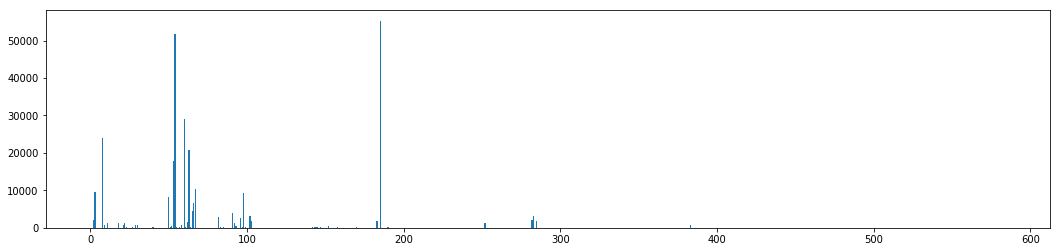

In [38]:
plt.figure(figsize=(18,4))
plt.bar(df_faults['ErrorCode'].value_counts().sort_index().index,
       df_faults['ErrorCode'].value_counts().sort_index().values)
plt.show()

What is the error code with the maximum number of occurrencies?

In [39]:
df_faults['ErrorCode'].value_counts().idxmax()

185

What tipe of error is it?

In [40]:
df_faults[df_faults['ErrorCode']==185]['Critical'].value_counts()

ONE         44448
WARNING     10763
CRITICAL       98
Name: Critical, dtype: int64

OK ... the same ErrorCode is of different category... maybe each machine has its own kind of erorr coding?
Let's see how many different 'Critical' values we have for each machine and for each error code:

In [41]:
df_faults.drop_duplicates(['Model','ErrorCode','Critical']).groupby(['Model','ErrorCode'])['Critical'].count()

Model                                   ErrorCode
??? - D41D8CD98F00B204E9800998ECF8427E  99           1
                                        103          1
model 1                                 98           2
                                        99           1
model 10                                3            2
                                        8            2
                                        9            2
                                        18           2
                                        21           2
                                        22           1
                                        24           2
                                        30           1
                                        50           2
                                        51           2
                                        52           2
                                                    ..
model 9                                 64           2
               

**Woops!** looks like the erorr types and error codes are badly mixed... so the error is defined by ErrorCode + Critical

For now I will ignore this weird condition, It will be an issue in the prediction

<font color=blue>**This should be cleaned with domain competence**</font>

**Let's see something of the cleanings**

How many cleaning error codes values and how many records per each one?

In [42]:
df_cleanings['ErrorCode'].value_counts()

1    35938
3    12408
5     9191
2     9167
4     7157
Name: ErrorCode, dtype: int64

Let's merge the cleanings in the faults dataset, by making the dataframe structure uniform.

To avoid mixing error codes, I add 1000 to cleaning codes, and I add the column "Critical" to the df_cleanings for uniformity with the faults dataset

In [43]:
df_cleanings['ErrorCode'] =  df_cleanings['ErrorCode'].add(1000) 
df_cleanings['Critical'] = 'CLEANING'
df_cleanings.head()

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,ErrorCode,Timestamp,Critical
0,1527654,2016,11,29,01:00:13,49,model 10,1001,2016-11-29 01:00:13,CLEANING
1,1496767,2016,11,29,00:00:00,49,model 7,1001,2016-11-29 00:00:00,CLEANING
2,1557536,2016,11,29,08:00:49,49,model 10,1002,2016-11-29 08:00:49,CLEANING
3,1558474,2016,11,29,01:00:35,49,model 9,1001,2016-11-29 01:00:35,CLEANING
4,1553390,2016,11,29,00:01:17,49,model 13,1001,2016-11-29 00:01:17,CLEANING


Now I can concatenate `df_faults` and `df_cleanings`

In [44]:
df_faults = pd.concat([df_faults,df_cleanings],sort=False)

In [45]:
# Error types per category
df_faults[['Critical','ErrorCode']].drop_duplicates()['Critical'].value_counts()

ONE         80
WARNING     53
CRITICAL    38
CLEANING     5
Name: Critical, dtype: int64

In [46]:
# Most frequent error codes?
df_faults['ErrorCode'].value_counts().head()


185     55309
54      51835
1001    35938
60      29141
8       24091
Name: ErrorCode, dtype: int64

How many faults recorded per model

In [47]:
df_faults['Model'].value_counts()

model 20                                  90743
model 13                                  79880
model 10                                  48821
model 18                                  29073
model 2                                   16203
model 9                                   15048
model 60                                  14830
model 5                                    7413
model 8                                    7153
model 39                                   6394
model 11                                   6007
model 33                                   4865
model 12                                   4840
model 7                                    3592
model 31                                   3220
                                          ...  
model 55                                     44
model 58                                     25
model 51                                     22
model 52                                     20
model 48                                

## Faults distribution across models
To explore this, let's summarize into a dataset indexed by machine model, starting with how many machines there are for each model and how many faults for each model

In [48]:
# Merge models_population with the number of faults recorded
df_issues_summary = pd.concat([models_population,
                               df_faults['Model'].value_counts()], axis=1,sort=False)
# Rename the columns
df_issues_summary.columns = ['Population','Faults']
df_issues_summary.head()

,Population,Faults
model 20,263,90743.0
model 10,183,48821.0
model 13,168,79880.0
model 9,150,15048.0
model 11,47,6007.0


Let's split the faults per type (or severity)

In [49]:
df_faults.groupby(['Critical','Model'])['Serial'].count().unstack(0).sort_values('CRITICAL',ascending=False).head()

Critical,CLEANING,CRITICAL,ONE,WARNING
Model,,,,
model 13,11729.0,36755.0,19616.0,11780.0
model 10,6549.0,12185.0,24904.0,5183.0
model 9,3642.0,1345.0,8785.0,1276.0
model 12,714.0,626.0,3080.0,420.0
model 17,554.0,579.0,1290.0,309.0


Same as above splitting per fault code

In [50]:
df_faults.groupby(['ErrorCode','Model'])['Serial'].count().unstack(0).head()

ErrorCode,1,2,3,7,8,9,11,18,20,21,22,23,24,25,26,27,29,30,31,40,41,42,44,45,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,82,83,84,85,88,89,90,91,92,93,95,96,97,98,99,102,103,142,143,144,145,147,148,151,152,158,166,170,182,183,185,190,251,252,266,270,282,283,285,351,352,366,383,421,451,483,583,1001,1002,1003,1004,1005
Model,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
??? - D41D8CD98F00B204E9800998ECF8427E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,88.0,14.0,15.0,11.0
model 10,NaN,NaN,1313.0,NaN,13404.0,202.0,NaN,496.0,NaN,9.0,1.0,NaN,6.0,NaN,NaN,NaN,NaN,284.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,989.0,10.0,86.0,NaN,12834.0,99.0,2.0,10.0,268.0,10.0,101.0,35.0,362.0,2388.0,103.0,1883.0,1011.0,1737.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,1363.0,349.0,12.0,NaN,121.0,15.0,118.0,43.0,2249.0,334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5213.0,674.0,662.0,NaN,NaN
model 11,NaN,NaN,108.0,NaN,313.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,52.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,14.0,24.0,NaN,10.0,11.0,1.0,1.0,44.0,1.0,NaN,1.0,39.0,1459.0,7.0,61.0,540.0,888.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,136.0,126.0,11.0,NaN,12.0,7.0,19.0,11.0,86.0,231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1616.0,102.0,NaN,NaN,NaN
model 12,NaN,NaN,413.0,NaN,888.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,11.0,6.0,NaN,95.0,NaN,6.0,NaN,41.0,NaN,NaN,3.0,25.0,64.0,21.0,81.0,359.0,1556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,235.0,4.0,9.0,NaN,18.0,1.0,37.0,19.0,47.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,588.0,50.0,57.0,19.0,NaN


Let's put all together

In [51]:
df_issues_summary = pd.concat([df_issues_summary, 
                               df_faults.groupby(['Critical','Model'])['Serial'].count().unstack(0),
                               df_faults.groupby(['ErrorCode','Model'])['Serial'].count().unstack(0)],sort=False,axis=1)
df_issues_summary.head()

,Population,Faults,CLEANING,CRITICAL,ONE,WARNING,1,2,3,7,8,9,11,18,20,21,22,23,24,25,26,27,29,30,31,40,41,42,44,45,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,82,83,84,85,88,89,90,91,92,93,95,96,97,98,99,102,103,142,143,144,145,147,148,151,152,158,166,170,182,183,185,190,251,252,266,270,282,283,285,351,352,366,383,421,451,483,583,1001,1002,1003,1004,1005
model 20,263,90743.0,289.0,144.0,70686.0,19624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,103.0,NaN,NaN,NaN,NaN,851.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.0,7674.0,NaN,NaN,NaN,NaN,2.0,4.0,24867.0,NaN,194.0,4209.0,NaN,NaN,NaN,NaN,NaN,746.0,76.0,NaN,NaN,NaN,9.0,NaN,NaN,3.0,NaN,10.0,60.0,2.0,6252.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,31.0,NaN,1.0,37.0,NaN,592.0,42835.0,NaN,16.0,4.0,7.0,1.0,310.0,836.0,7.0,3.0,39.0,4.0,540.0,NaN,NaN,3.0,NaN,289.0,NaN,NaN,NaN,NaN
model 10,183,48821.0,6549.0,12185.0,24904.0,5183.0,NaN,NaN,1313.0,NaN,13404.0,202.0,NaN,496.0,NaN,9.0,1.0,NaN,6.0,NaN,NaN,NaN,NaN,284.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,989.0,10.0,86.0,NaN,12834.0,99.0,2.0,10.0,268.0,10.0,101.0,35.0,362.0,2388.0,103.0,1883.0,1011.0,1737.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,1363.0,349.0,12.0,NaN,121.0,15.0,118.0,43.0,2249.0,334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5213.0,674.0,662.0,NaN,NaN
model 13,168,79880.0,11729.0,36755.0,19616.0,11780.0,NaN,NaN,3964.0,NaN,6052.0,7.0,NaN,NaN,NaN,26.0,1139.0,NaN,8.0,NaN,NaN,6.0,NaN,76.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,4878.0,3.0,35.0,NaN,33241.0,109.0,2.0,61.0,203.0,25.0,1.0,24.0,148.0,8498.0,43.0,1869.0,2495.0,2458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,623.0,817.0,11.0,NaN,129.0,69.0,30.0,23.0,458.0,603.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4265.0,3205.0,4259.0,NaN,NaN
model 9,150,15048.0,3642.0,1345.0,8785.0,1276.0,NaN,NaN,552.0,NaN,1369.0,10.0,NaN,NaN,NaN,125.0,50.0,NaN,NaN,NaN,NaN,279.0,NaN,193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1701.0,NaN,54.0,2.0,617.0,54.0,3.0,20.0,161.0,5.0,3.0,11.0,101.0,1501.0,19.0,193.0,958.0,2223.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,524.0,4.0,21.0,NaN,66.0,31.0,78.0,70.0,155.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3132.0,290.0,212.0,8.0,NaN
model 11,47,6007.0,1718.0,578.0,3140.0,571.0,NaN,NaN,108.0,NaN,313.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,52.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,14.0,24.0,NaN,10.0,11.0,1.0,1.0,44.0,1.0,NaN,1.0,39.0,1459.0,7.0,61.0,540.0,888.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,136.0,126.0,11.0,NaN,12.0,7.0,19.0,11.0,86.0,231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1616.0,102.0,NaN,NaN,NaN


The absolute number of faults per machine type does not say much. 

Let's compute the *ratio* of faults per machine type

In [52]:
# create a dataframe as df_issues_summary with absolute values divided by the number of machines of a certain model
df_issues_summary_rate = df_issues_summary[df_issues_summary.columns[1:]]\
                .div(df_issues_summary['Population'], axis=0)
# add again the population column
df_issues_summary_rate['Population'] = df_issues_summary['Population']

### Worst list - models with higher faults ratio

Only listing models with no less than `minimum_number_of_machines` machines

In [53]:
minimum_number_of_machines = 10

In [54]:
_df = df_issues_summary_rate[df_issues_summary_rate['Population']>=minimum_number_of_machines]

In [55]:
_df[['Population','Faults','ONE','CRITICAL','WARNING','CLEANING']]\
                          .sort_values('Faults',ascending=False)

,Population,Faults,ONE,CRITICAL,WARNING,CLEANING
model 5,15,494.200000,356.666667,1.400000,67.600000,68.533333
model 13,168,475.476190,116.761905,218.779762,70.119048,69.815476
model 60,40,370.750000,354.900000,0.025000,15.825000,NaN
model 20,263,345.030418,268.768061,0.547529,74.615970,1.098859
model 10,183,266.781421,136.087432,66.584699,28.322404,35.786885
model 17,14,195.142857,92.142857,41.357143,22.071429,39.571429
model 31,17,189.411765,171.294118,0.058824,14.000000,4.058824
model 8,41,174.463415,83.219512,13.975610,4.487805,72.780488
model 16,14,157.785714,110.928571,0.142857,0.071429,46.642857
model 50,21,152.095238,130.095238,NaN,20.571429,1.428571


**Higher ratios of missed cleanings**

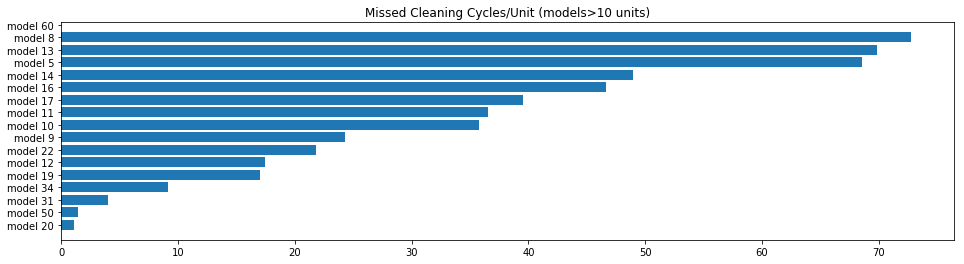

In [56]:
plt.figure(figsize=(16,4))
plt.barh(_df['CLEANING'].sort_values().index,
         _df['CLEANING'].sort_values())
plt.title("Missed Cleaning Cycles/Unit (models>10 units)")
plt.show()

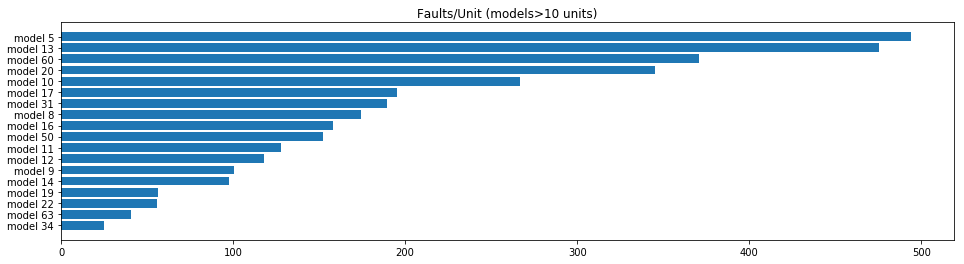

In [57]:
plt.figure(figsize=(16,4))
plt.barh(_df['Faults'].sort_values().index,
         _df['Faults'].sort_values())
plt.title("Faults/Unit (models>10 units)")
plt.show()

## Timeline
Before builindg the predictive modes, what is the right timeline for our data? Le't see firs ant last samples of our datasets

**Counters:**

In [58]:
df_counters.groupby('Model').agg({'Timestamp':[min,max]}).sort_values(('Timestamp','min')).head(10)

Timestamp                    
                         min                 max
Model                                           
model 63 1999-11-30 00:07:00 2018-02-07 23:00:24
model 72 1999-11-30 00:07:00 2018-02-07 18:10:26
model 4  2001-02-12 08:50:31 2018-02-07 00:00:33
model 20 2001-03-10 17:05:32 2018-02-07 23:03:15
model 10 2016-03-16 16:44:19 2018-02-07 23:21:09
model 9  2016-10-17 10:00:49 2018-02-07 23:00:31
model 13 2016-11-29 00:00:00 2018-02-07 23:00:59
model 11 2016-11-29 00:00:01 2018-02-07 23:00:30
model 30 2016-11-29 00:00:02 2017-10-20 13:00:29
model 3  2016-11-29 00:00:06 2017-10-18 00:05:28

**Faults**

In [59]:
df_faults.groupby('Model').agg({'Timestamp':[min,max]}).sort_values(('Timestamp','min')).head(10)

Timestamp                    
                         min                 max
Model                                           
model 20 1999-11-30 00:00:00 2018-02-06 22:47:00
model 55 2001-02-12 07:59:00 2018-01-08 09:00:00
model 4  2001-02-12 08:32:00 2018-01-18 00:00:00
model 31 2001-03-05 11:40:00 2018-02-06 23:42:00
model 2  2012-01-04 08:31:00 2018-02-06 00:00:00
model 60 2015-03-25 09:54:00 2018-02-06 20:34:00
model 10 2015-11-03 09:37:19 2018-02-06 23:25:05
model 9  2016-04-24 23:01:25 2018-02-06 21:38:29
model 27 2016-06-01 13:59:00 2018-02-06 00:00:00
model 5  2016-06-05 17:31:00 2018-02-06 20:56:00

Looks like some models were recording faults before having recorded any counter.

Let's consider records >= 2016 (so there are both counters and faults indications)


<font color=blue>**This should be cleaned with domain competence**</font>

In [376]:
df_faultsf = df_faults[df_faults['Timestamp']>pd.Timestamp("2016")]
df_countersf = df_counters[df_counters['Timestamp']>pd.Timestamp("2016")]


### Timeline of Faults (absolute)

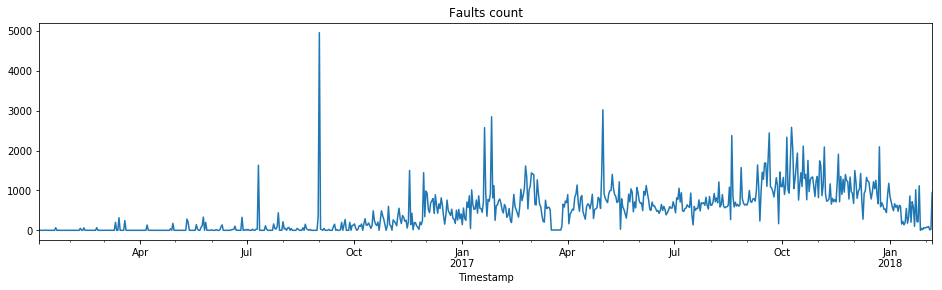

In [377]:
plt.figure(figsize=(16,4))
df_faultsf.groupby('Timestamp')['Critical'].count().resample('D').sum().plot()
plt.title("Faults count")
plt.show()

What is the peak on September 2016??
Let's get the exact day:

In [378]:
df_faultsf.groupby('Timestamp')['Critical'].count().resample('D').sum().idxmax()

Timestamp('2016-09-01 00:00:00', freq='D')

Then filter the dataset looking for only that exact date

In [379]:
bad_day = df_faultsf['Timestamp'].apply(lambda t: t.date())==pd.Timestamp('2016-09-01').date()
df_faultsf[bad_day]

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,ErrorCode,Critical,Timestamp
439,1549699,2016,9,1,00:18:00,36,model 39,53,ONE,2016-09-01 00:18:00
440,1549699,2016,9,1,01:07:00,36,model 39,53,ONE,2016-09-01 01:07:00
441,1549699,2016,9,1,01:55:00,36,model 39,53,ONE,2016-09-01 01:55:00
442,1549699,2016,9,1,04:00:00,36,model 39,53,ONE,2016-09-01 04:00:00
443,1549699,2016,9,1,04:09:00,36,model 39,53,ONE,2016-09-01 04:09:00
444,1549699,2016,9,1,04:35:00,36,model 39,53,ONE,2016-09-01 04:35:00
445,1549699,2016,9,1,04:38:00,36,model 39,53,ONE,2016-09-01 04:38:00
446,1549699,2016,9,1,04:58:00,36,model 39,53,ONE,2016-09-01 04:58:00
447,1549699,2016,9,1,05:14:00,36,model 39,53,ONE,2016-09-01 05:14:00
448,1549699,2016,9,1,05:26:00,36,model 39,53,ONE,2016-09-01 05:26:00


May be just few machines going mad?

In [380]:
df_faultsf[bad_day]['Critical'].value_counts()

ONE         4840
CLEANING     116
Name: Critical, dtype: int64

In [381]:
df_faultsf[bad_day]['Serial'].value_counts()

1549699    4840
1421318     116
Name: Serial, dtype: int64

So looks like one machine, SN 1549699 (model 39) had a very bad day and one other, SN 1421318 missed 116 times the cleanings in the same day.

Looking for crazy number of errors on the same machine or missed cleanings multiple times in the same day may be a pattern to look at for cleaning the data, but I'm not yet doing it

### Timeline of Faults (per fault type)

Let's split the faults timeline across faults types.

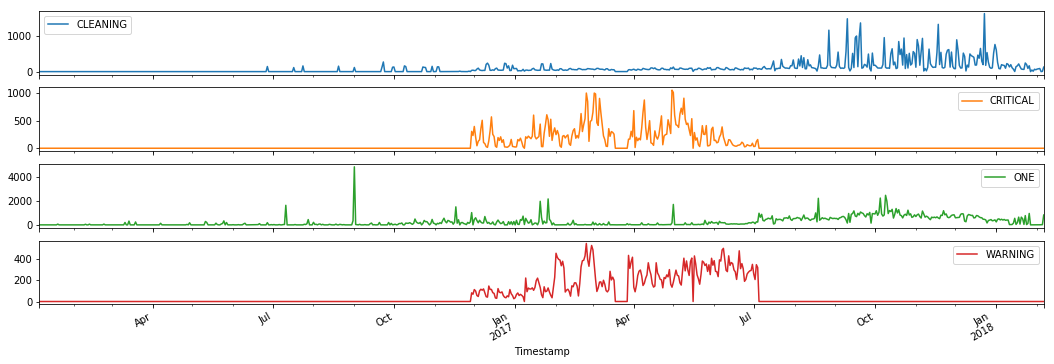

In [382]:
df_faultsf.groupby(['Critical','Timestamp'])['Serial'].count()\
           .unstack('Critical').resample('D').sum().plot(figsize=(18,6),subplots=True)
plt.show()

The distribution is quite strange:
* "CRITICAL" and "WARNING" faults types have been observed only in a time window from end 2016 until august 2017 or so.
* "CLEANING" events are  concentrated after mid 2017
* "ONE" events are distributed across all timeline

*be careful:* the orders of magnitude are very different: CLEANING and ONE are in the hundreds, others in the units.
Resampling over Weeks instead of days brings scales back in line amonng fault types

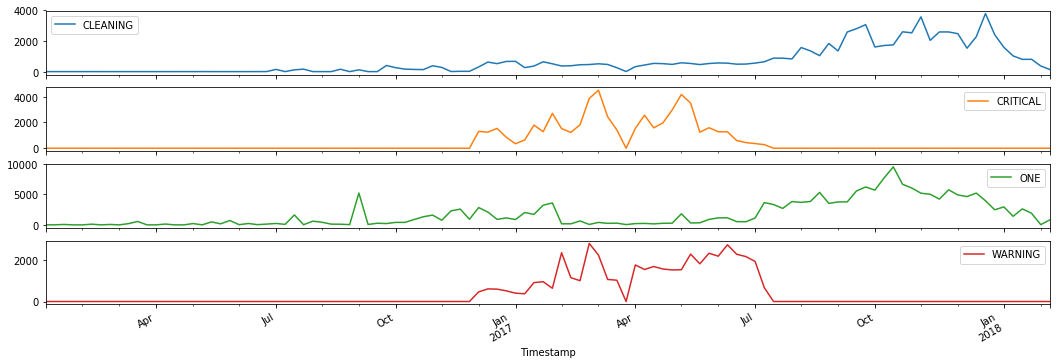

In [383]:
df_faultsf.groupby(['Critical','Timestamp'])['Serial'].count()\
           .unstack('Critical').resample('W').sum().plot(figsize=(18,6),subplots=True)
plt.show()

### Timeline of faults (per machine type)

Look only at the top 4 machines in terms of population 

In [384]:
models_to_look = models_population.sort_values(ascending=False)[:4].index


Let's resample on Week basis from the beginning

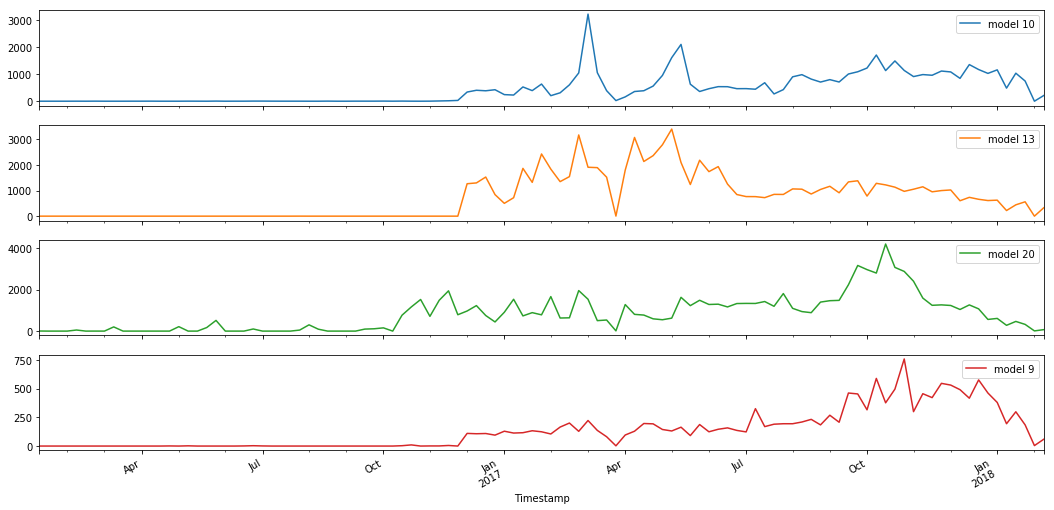

In [385]:
df_faultsf[df_faultsf['Model'].isin(models_to_look)]\
           .groupby(['Model','Timestamp'])['Serial'].count()\
           .unstack('Model').resample('W').sum().plot(figsize=(18,9),subplots=True)
plt.show()

### Timeline on counters (per machine type)

Let's check when exactly machines start genereting counters

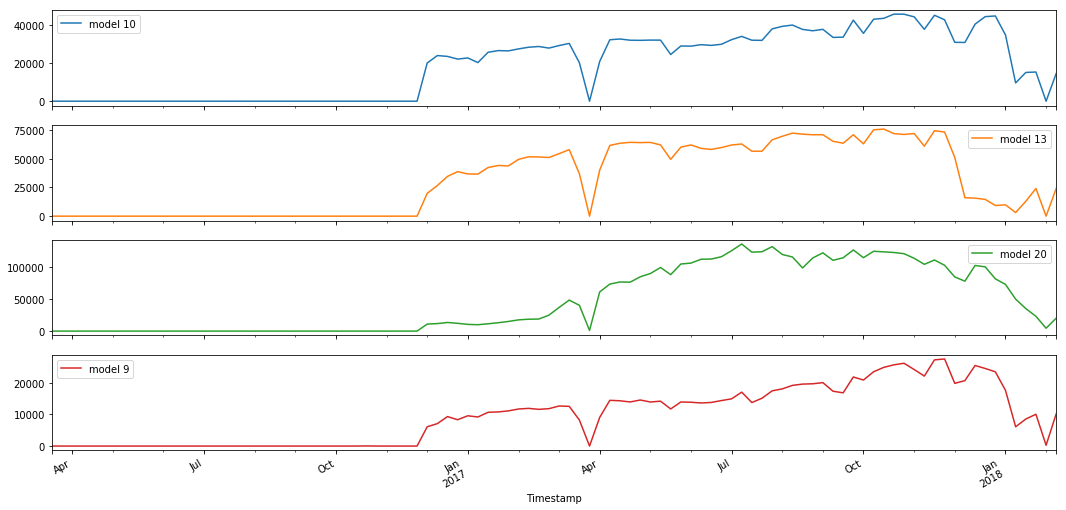

In [386]:
df_countersf[df_countersf['Model'].isin(models_to_look)]\
            .groupby(['Model','Timestamp'])['Serial'].count().unstack('Model')\
            .resample('W').sum().plot(figsize=(18,9),subplots=True)
plt.show()

So no much sense in looking for anything before Oct 2016

In [387]:
df_faultsf = df_faults[df_faults['Timestamp']>pd.Timestamp("2016-10-01")]
df_countersf = df_counters[df_counters['Timestamp']>pd.Timestamp("2016-10-01")]


# Building the dataset for prediction

I will build a datset for predicting faults based on previous faults and missed cleanings.
The dataset will be extended also including counters, but I had problems I cannot yet fix :-(

The datset format will be like the following 


Serial | Model | Timestamp | FAULT-4D | FAULT-3D | FAULT-2D | FAULT-1D | CLEANING-4D | CLEANING-3D | CLEANING-2D | CLEANING-1D | TARGET |
-------|-------|-----------|----------|----------|----------|----------|-------------|-------------|-------------|---------------------|--------|
1535632 | model 62 | 2017-02-12 00:00:00 | 0 |  1 |  0 |  5 |  0 |   0 |  0 | 2 | 0  |  
1425579 | model 20 | 2017-03-06 00:00:00 | 1 | 36 | 18 |  2 |  0 |  12 | 90 | 2 | 11 | 

The parameters are the sampling rate and depth.
In the example above the sampling rate is one day (`D`) and the depth is 4 days.

`FAULT-4D` means how many errors have been registered by that machine 4 Days ahead fo the target day

`FAULT-3D` means how many errors have been registered by that machine 3 Days ahead fo the target day, and so on

`CLEANING-4D` means how many errors have been registered by that machine 4 Days ahead fo the target day, and so on

`Timestamp` is referred to the Target event we want to predict

`TARGET` is the target of the prediction. In the present notebook it is the number of errors on the target day.

The depth makes sense of much more days, say at least 10 but 30 wold make better sense. The period could be weeks (`W`) to make a smaller dataset.

In [388]:
df_faultsf.head()

,Serial,YYYY,MM,dd,hh:mm:ss,Week,Model,ErrorCode,Critical,Timestamp
0,1496700,2016,11,29,16:57:00,49,model 62,285,WARNING,2016-11-29 16:57:00
1,1458460,2016,11,29,19:54:00,49,model 20,185,WARNING,2016-11-29 19:54:00
2,1528607,2016,11,29,14:44:00,49,model 20,185,WARNING,2016-11-29 14:44:00
3,1528607,2016,11,29,17:34:00,49,model 20,185,WARNING,2016-11-29 17:34:00
4,1425579,2016,11,29,17:19:00,49,model 20,185,WARNING,2016-11-29 17:19:00


I will need a lookup table between Serial numbers and Models

Wait a minute... let's check if association between SN and model is coherent. And let's concatenate both faults and counters dataframes, to make sure to collect all!

In [389]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
    .groupby('Serial')['Model'].count().sort_values(ascending=False).head()


Serial
1536009    2
1587623    2
1566832    1
1566315    1
1566316    1
Name: Model, dtype: int64

Looks like there are few SN associated to more than one mode, let's see:

In [390]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
    .groupby('Serial').get_group('1587623')

,Serial,Model
2595,1587623,??? - D41D8CD98F00B204E9800998ECF8427E
1079,1587623,model 11


This is easy - the crazy string is an error - Let's fix this once and forever:

<font color=red>**This assumption is wrong - after check with Flairbit, this is due to an issue in the process of dataset anonymization**</font>

In [392]:
# if-then on one column, see
# http://pandas-docs.github.io/pandas-docs-travis/user_guide/cookbook.html
df_faultsf.loc[df_faultsf['Serial']=='1587623','Model'] = 'model 11'
df_countersf.loc[df_countersf['Serial']=='1587623','Model'] = 'model 11'


C:\Users\emamorc\AppData\Local\conda\conda\envs\py36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


We have a warning but I'm not sure this is appropriate. Actually we are doing right what the warning suggests.

Let's see the other duplicated SN

In [393]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
    .groupby('Serial').get_group('1536009')

,Serial,Model
64632,1536009,model 55
47612,1536009,model 63


This is worst... which will be true? Let's check by majority

In [394]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]])\
            .set_index('Serial').loc['1536009']['Model'].value_counts()

model 63    57
model 55    47
Name: Model, dtype: int64

Hard choice --- they are sort of the same amount. Let's see how they are in the timeline

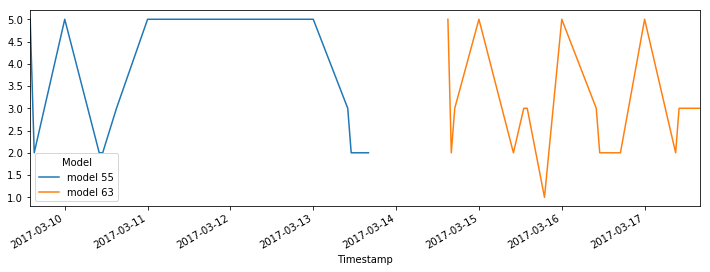

In [395]:
pd.concat([df_faultsf[['Serial','Model','Timestamp']],df_countersf[['Serial','Model','Timestamp']]])\
            .set_index('Serial').loc['1536009'].reset_index().groupby(['Timestamp','Model'])['Serial'].count()\
            .unstack('Model').plot(figsize=(12,4))

Let's assume the right one is the last one, i.e. "model 63" 

In [396]:
# if-then on one column, see
# http://pandas-docs.github.io/pandas-docs-travis/user_guide/cookbook.html
df_faultsf.loc[df_faultsf['Serial']=='1536009','Model'] = 'model 63'
df_countersf.loc[df_countersf['Serial']=='1536009','Model'] = 'model 63'

And finally check if all is OK

In [397]:
pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
    .groupby('Serial')['Model'].count().sort_values(ascending=False).head()

Serial
1709778    1
1566832    1
1566315    1
1566316    1
1566317    1
Name: Model, dtype: int64

Good, looks like  there are no serial numbers replications

Now I can build a safe lookup table!

In [398]:
sn_model_lookup =pd.concat([df_faultsf[['Serial','Model']],df_countersf[['Serial','Model']]]).drop_duplicates()\
                            .set_index('Serial').sort_index()
sn_model_lookup.head()

,Model
Serial,
1000002,model 17
1000009,model 17
1100001,model 15
1111222,model 1
1111333,model 20


### Subsetting the Serial Numbers

To run experiments I limit the number of serial numbers to play with to the ones with more fault records associated, using `value_counts`

In [399]:
how_many_serials = 101 # set this to -1 to pick all serials
if how_many_serials > 0:
    top_serial = df_faultsf['Serial'].value_counts().head(how_many_serials).index
else:
    top_serial = df_faultsf['Serial'].value_counts().index

### Manipulation of faults dataframe
I copy in a new DataFrame the subset fo the filtered fault dataframe, with further filter on the Serial numbers, and removing the columns which we don't use any more


In [400]:
my_faults_mask = df_faultsf['Serial'].isin(set(top_serial))
_df_faults = df_faultsf[my_faults_mask].drop(['YYYY', 'MM', 'dd', 'hh:mm:ss','Week','Model'],axis=1).copy()


I transoform all the error lables like "CRITICAL", "WARNING", "ONE" into just one label "FAULT".

In [401]:
# if-then on one column, see
# http://pandas-docs.github.io/pandas-docs-travis/user_guide/cookbook.html
_df_faults.loc[_df_faults['Critical'] != 'CLEANING','Critical'] = 'FAULT'

### Time period setting
This is the time period between samples in each row of the final dataset

In [402]:
time_period = 'D'

### Depth, step and target setting

With `depth = 10` there will be 10 coulumns with FAULTS history and 10 columns with CLEANING history in the dataset.

With `step = 1` between one row and the next row of the same Serial there will be a shift one period.

The target coulumn in the dataset will be the vale of the column FAULT after "depth" steps

In [405]:
depth = 20
step  = 1
target_field = 'FAULT'

## Merge Faults and Counters

To have a single timeline I will merge the two datasets of Faults and Counters. Let's start by getting counters in the same kind of subset as done for tha faults

In [406]:
my_counters_mask = df_countersf['Serial'].isin(set(top_serial))
_df_counters = df_countersf[my_counters_mask].drop(['YYYY', 'MM', 'dd', 'hh:mm:ss','Week','Model','check_max'],axis=1)

In [407]:
_df_counters.head()

,Serial,LabelCounter,AbsoluteCounter,RelativeCounter,Timestamp
408,1479635,numcaffegenerale,243719.0,0.0,2016-11-29 00:00:32
412,1479635,numcaffegenerale,243722.0,3.0,2016-11-29 04:00:17
413,1479635,numcaffegenerale,243727.0,5.0,2016-11-29 05:00:15
415,1479635,numcaffegenerale,243739.0,12.0,2016-11-29 07:00:15
416,1479635,numcaffegenerale,243766.0,27.0,2016-11-29 08:00:16


In [408]:
_df_faults.head()

,Serial,ErrorCode,Critical,Timestamp
6,1468215,185,FAULT,2016-11-29 15:24:00
7,1468215,185,FAULT,2016-11-29 16:31:00
8,1468215,185,FAULT,2016-11-29 17:43:00
9,1517618,185,FAULT,2016-11-29 18:15:00
10,1517618,185,FAULT,2016-11-29 18:59:00


We will convert the faults DataFrame in a format compatible with the counters dataframe, introducing Relative and Absolute counters. Relative counter is easy: each Record will be a single event, so each row will have relative counter = 1

In [409]:
_df_faults['RelativeCounter'] = 1

For the absolute counter I have to identify the portions of dataset relavent to a certain serial and a certain type of fault, and count the events.

In [410]:
serials = list(sn_model_lookup.index)

# start stopwatch ... this will take long
start = dt.datetime.now()

for n,sn in enumerate(serials):
    # To be as general as possible I get the list of items associated to each serial number every time
    items = _df_faults[_df_faults['Serial']==sn]['Critical'].unique()
    if len(items)>0:
        for i in items:
            _df_faults.loc[(_df_faults['Serial']==sn)&(_df_faults['Critical']==i),'AbsoluteCounter'] = \
                    _df_faults.groupby(['Serial','Critical']).get_group((sn,i))['RelativeCounter'].cumsum()
    progress(n, len(serials)-1, status='Building Absolute fault counters')
    
print('\n',(dt.datetime.now()-start))

[============================================================] 100.0% ...Building Absolute fault counters
 0:00:29.683249


Let's give a look (now I will sample some rows at random)

In [411]:
_df_faults.sample(5)

,Serial,ErrorCode,Critical,Timestamp,RelativeCounter,AbsoluteCounter
18,1421318,2,FAULT,2017-01-20 15:53:00,1,4689.0
237,1612713,1005,CLEANING,2017-10-23 00:00:00,1,7644.0
26,1343587,1001,CLEANING,2017-01-28 00:00:00,1,871.0
177,1427255,185,FAULT,2017-01-02 20:15:00,1,1004.0
250,1604016,53,FAULT,2017-12-16 09:01:00,1,4275.0


Next steps: rename Crticial into LabelCounter and remove "ErrorCode"

In [412]:
_df_faults['LabelCounter'] = _df_faults['Critical']
_df_faults = _df_faults.drop(['ErrorCode','Critical'],axis = 1)
_df_faults.head()

,Serial,Timestamp,RelativeCounter,AbsoluteCounter,LabelCounter
6,1468215,2016-11-29 15:24:00,1,1.0,FAULT
7,1468215,2016-11-29 16:31:00,1,2.0,FAULT
8,1468215,2016-11-29 17:43:00,1,3.0,FAULT
9,1517618,2016-11-29 18:15:00,1,1.0,FAULT
10,1517618,2016-11-29 18:59:00,1,2.0,FAULT


# READY TO MERGE!!!!

Let's give another look to the counters df, final check if it matches the faults df (I use the columns name of the  `_df_faults` dataset to better compare)

In [415]:
_df_counters[_df_faults.columns].head()

,Serial,Timestamp,RelativeCounter,AbsoluteCounter,LabelCounter
408,1479635,2016-11-29 00:00:32,0.0,243719.0,numcaffegenerale
412,1479635,2016-11-29 04:00:17,3.0,243722.0,numcaffegenerale
413,1479635,2016-11-29 05:00:15,5.0,243727.0,numcaffegenerale
415,1479635,2016-11-29 07:00:15,12.0,243739.0,numcaffegenerale
416,1479635,2016-11-29 08:00:16,27.0,243766.0,numcaffegenerale


Let's concatenate the two:

In [416]:
_df_faults_and_counters = pd.concat([_df_counters,_df_faults],sort=False)
_df_faults_and_counters.sample(10)

,Serial,LabelCounter,AbsoluteCounter,RelativeCounter,Timestamp
18997,1565931,numcaffegenerale,29360.0,20.0,2017-02-09 12:00:40
34831,1542283,numcaffegr1,31249.0,8.0,2017-05-14 09:00:11
59669,1590517,numcaffegr3,43791.0,20.0,2017-07-04 10:00:15
21119,1557339,numcaffegr1,57671.0,20.0,2017-07-11 09:00:29
19073,1565929,numcaffegenerale,73976.0,18.0,2017-10-23 15:00:26
19764,1558464,numcicligr1,52991.0,17.0,2017-04-03 11:00:42
119889,1558041,numacqua,15401.0,3.0,2017-11-19 09:00:26
143307,1612713,numcaffegr1,52527.0,6.0,2017-11-26 13:11:17
23512,1519204,ngr2,96.0,2.0,2017-11-28 19:05:08
9697,1558697,numlattegr1,92194.0,6.0,2017-06-21 19:00:16


In [417]:
labels  = _df_faults_and_counters['LabelCounter'].unique()
mintime = _df_faults_and_counters['Timestamp'].min()
serials = _df_faults_and_counters['Serial'].unique()

Machines of different models have different counters labels. I want an uniform dataset so let's fill in the missing lables with one dummy sample, with Absolute Counter = -1 and Relative Counter = -1.

To spot the missing labels I group per serial and per Label counting records. Unstacking the LabelCounter on the columns, will leave "NaN" where there is no counter. 

In [420]:

missing_labels = _df_faults_and_counters.groupby(['Serial','LabelCounter'])\
                    ['Timestamp'].count().unstack('LabelCounter').isna()
missing_labels.head()

LabelCounter,CLEANING,FAULT,ngr1,ngr2,ngr3,ngr4,numacqua,numcaffegenerale,numcaffegr1,numcaffegr2,numcaffegr3,numcaffegr4,numcicligr1,numcioccolato,numlattefr,numlattegr1,nummac1gr1,nummac2gr1,numsolubile,numvapore,numvaporeariats,numvaporets,portatagr1,portatagr2,portatagr3,portatagr4,tempogr1,tempogr2,tempogr3,tempogr4
Serial,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1111333,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False,False,False,False,False,True,False,False,False,True
1269672,False,False,True,True,True,True,True,False,False,True,True,True,False,False,True,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True
1285802,False,False,True,True,True,True,True,False,False,True,True,True,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True
1343587,False,False,True,True,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True
1381715,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,False,False,False,True


Then I go through the Serial Numbers and I add one dummy record per each unexistent label with -1 in counters

In [421]:
# start stopwatch ... this will take long
start = dt.datetime.now()

_df_patch = pd.DataFrame(columns=_df_faults_and_counters.columns)
for i,sn in enumerate(serials):
    progress(i,len(serials)-1, status=sn+'     ')
    my_labels = missing_labels.loc[sn][missing_labels.loc[sn]].index
    for label in my_labels:
        _df_patch = pd.concat([_df_patch,
                        pd.DataFrame([[sn,label,-1.0,-1.0,mintime]], columns=_df_faults_and_counters.columns)])
    progress(i,len(serials)-1, status=sn+'     ')

print('\n',(dt.datetime.now()-start))



[============================================================] 100.0% ...1682130     
 0:00:02.304496


In [422]:
_df_faults_and_counters = pd.concat([_df_patch,_df_faults_and_counters])

In [423]:
from functools import reduce
import operator
labels_ixd = reduce(operator.concat, [['%s-%d%s'%(l,i,str(time_period)) for i in range(depth,0,-1)] for l in labels])
header     = ['Serial','Model','Target Timestamp','TARGET',*labels_ixd]

### Loop to build the dataset

To build the dataset I will loop across the the series shifting the initial timestamp, for each serial number and for "depth" steps at each time 

In [424]:
start = dt.datetime.now()
gb = _df_faults_and_counters.groupby(['Serial'])

dataset = pd.DataFrame(columns=header)
for i,sn in enumerate(serials):
    model = sn_model_lookup.loc[sn][0]
    progress(i, len(serials)-1, status='%s-%s'%(sn,model))
    date_last  = gb.get_group(sn)['Timestamp'].max().date()
    date_first = gb.get_group(sn)['Timestamp'].min().date()
    dr = pd.date_range(date_first, date_last, freq='D')
    # Multi index for for all life of this sn
    mux = pd.MultiIndex.from_product([labels,dr],names=['Timestamp','LabelCounter'])
    sn_history = gb.get_group(sn).groupby('LabelCounter')['Timestamp','RelativeCounter'].\
                 resample(rule=time_period,on='Timestamp')['RelativeCounter'].sum().reindex(mux,fill_value=0)
    # Intialize an empty DataFrame
    dataset_sn = pd.DataFrame(columns=header)
    for offset in range(len(dr)-depth):
        dates = dr[offset:offset+depth]
        # Multiindex for life of sn from offset to offset+depth
        mini_mux = pd.MultiIndex.from_product([labels,dates],names=['Timestamp','LabelCounter'])
        new_line = pd.DataFrame([[sn,                                              # Serial number
                                  model,                                           # Model looked up in the lookup table
                                  dr[offset+depth].date(),                         # Target date for this row
                                  sn_history.loc[target_field,dr[offset+depth]][0],# TARGET Column
                             *sn_history.loc[mini_mux]['RelativeCounter'].values]],# portion of history for depth periods 
                                  columns = header)
        dataset_sn = pd.concat([dataset_sn,new_line])     
    dataset = pd.concat([dataset,dataset_sn])    

print('\n',(dt.datetime.now()-start))

[============================================================] 100.0% ...1682130-model 9
 0:29:24.527844


In [425]:
dataset.head(10)

,Serial,Model,Target Timestamp,TARGET,numcaffegenerale-20D,numcaffegenerale-19D,numcaffegenerale-18D,numcaffegenerale-17D,numcaffegenerale-16D,numcaffegenerale-15D,numcaffegenerale-14D,numcaffegenerale-13D,numcaffegenerale-12D,numcaffegenerale-11D,numcaffegenerale-10D,numcaffegenerale-9D,numcaffegenerale-8D,numcaffegenerale-7D,numcaffegenerale-6D,numcaffegenerale-5D,numcaffegenerale-4D,numcaffegenerale-3D,numcaffegenerale-2D,numcaffegenerale-1D,numcaffegr1-20D,numcaffegr1-19D,numcaffegr1-18D,numcaffegr1-17D,numcaffegr1-16D,numcaffegr1-15D,numcaffegr1-14D,numcaffegr1-13D,numcaffegr1-12D,numcaffegr1-11D,numcaffegr1-10D,numcaffegr1-9D,numcaffegr1-8D,numcaffegr1-7D,numcaffegr1-6D,numcaffegr1-5D,numcaffegr1-4D,numcaffegr1-3D,numcaffegr1-2D,numcaffegr1-1D,numcaffegr2-20D,numcaffegr2-19D,numcaffegr2-18D,numcaffegr2-17D,numcaffegr2-16D,numcaffegr2-15D,numcaffegr2-14D,numcaffegr2-13D,numcaffegr2-12D,numcaffegr2-11D,numcaffegr2-10D,numcaffegr2-9D,numcaffegr2-8D,numcaffegr2-7D,numcaffegr2-6D,numcaffegr2-5D,numcaffegr2-4D,numcaffegr2-3D,numcaffegr2-2D,numcaffegr2-1D,numacqua-20D,numacqua-19D,numacqua-18D,numacqua-17D,numacqua-16D,numacqua-15D,numacqua-14D,numacqua-13D,numacqua-12D,numacqua-11D,numacqua-10D,numacqua-9D,numacqua-8D,numacqua-7D,numacqua-6D,numacqua-5D,numacqua-4D,numacqua-3D,numacqua-2D,numacqua-1D,numcaffegr3-20D,numcaffegr3-19D,numcaffegr3-18D,numcaffegr3-17D,numcaffegr3-16D,numcaffegr3-15D,numcaffegr3-14D,numcaffegr3-13D,numcaffegr3-12D,numcaffegr3-11D,numcaffegr3-10D,numcaffegr3-9D,numcaffegr3-8D,numcaffegr3-7D,numcaffegr3-6D,numcaffegr3-5D,numcaffegr3-4D,numcaffegr3-3D,numcaffegr3-2D,numcaffegr3-1D,numvaporets-20D,numvaporets-19D,numvaporets-18D,numvaporets-17D,numvaporets-16D,numvaporets-15D,numvaporets-14D,numvaporets-13D,numvaporets-12D,numvaporets-11D,numvaporets-10D,numvaporets-9D,numvaporets-8D,numvaporets-7D,numvaporets-6D,numvaporets-5D,numvaporets-4D,numvaporets-3D,numvaporets-2D,numvaporets-1D,numvaporeariats-20D,numvaporeariats-19D,numvaporeariats-18D,numvaporeariats-17D,numvaporeariats-16D,numvaporeariats-15D,numvaporeariats-14D,numvaporeariats-13D,numvaporeariats-12D,numvaporeariats-11D,numvaporeariats-10D,numvaporeariats-9D,numvaporeariats-8D,numvaporeariats-7D,numvaporeariats-6D,numvaporeariats-5D,numvaporeariats-4D,numvaporeariats-3D,numvaporeariats-2D,numvaporeariats-1D,portatagr1-20D,portatagr1-19D,portatagr1-18D,portatagr1-17D,portatagr1-16D,portatagr1-15D,portatagr1-14D,portatagr1-13D,portatagr1-12D,portatagr1-11D,portatagr1-10D,portatagr1-9D,portatagr1-8D,portatagr1-7D,portatagr1-6D,portatagr1-5D,portatagr1-4D,portatagr1-3D,portatagr1-2D,portatagr1-1D,portatagr2-20D,portatagr2-19D,portatagr2-18D,portatagr2-17D,portatagr2-16D,portatagr2-15D,portatagr2-14D,portatagr2-13D,portatagr2-12D,portatagr2-11D,portatagr2-10D,portatagr2-9D,portatagr2-8D,portatagr2-7D,portatagr2-6D,portatagr2-5D,portatagr2-4D,portatagr2-3D,portatagr2-2D,portatagr2-1D,portatagr3-20D,portatagr3-19D,portatagr3-18D,portatagr3-17D,portatagr3-16D,portatagr3-15D,portatagr3-14D,portatagr3-13D,portatagr3-12D,portatagr3-11D,portatagr3-10D,portatagr3-9D,portatagr3-8D,portatagr3-7D,portatagr3-6D,portatagr3-5D,portatagr3-4D,portatagr3-3D,portatagr3-2D,portatagr3-1D,tempogr1-20D,tempogr1-19D,tempogr1-18D,tempogr1-17D,tempogr1-16D,tempogr1-15D,tempogr1-14D,tempogr1-13D,tempogr1-12D,tempogr1-11D,tempogr1-10D,tempogr1-9D,tempogr1-8D,tempogr1-7D,tempogr1-6D,tempogr1-5D,tempogr1-4D,tempogr1-3D,tempogr1-2D,tempogr1-1D,tempogr2-20D,tempogr2-19D,tempogr2-18D,tempogr2-17D,tempogr2-16D,tempogr2-15D,tempogr2-14D,tempogr2-13D,tempogr2-12D,tempogr2-11D,tempogr2-10D,tempogr2-9D,tempogr2-8D,tempogr2-7D,tempogr2-6D,tempogr2-5D,tempogr2-4D,tempogr2-3D,tempogr2-2D,tempogr2-1D,ngr1-20D,ngr1-19D,ngr1-18D,ngr1-17D,ngr1-16D,ngr1-15D,ngr1-14D,ngr1-13D,ngr1-12D,ngr1-11D,ngr1-10D,ngr1-9D,ngr1-8D,ngr1-7D,ngr1-6D,ngr1-5D,ngr1-4D,ngr1-3D,ngr1-2D,ngr1-1D,ngr2-20D,ngr2-19D,ngr2-18D,ngr2-17D,ngr2-16D,ngr2-15D,ngr2-14D,ngr2-13D,ngr2-12D,ngr2-11D,ngr2-10D,ngr2-9D,ngr2-8D,ngr2

In [426]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45323 entries, 0 to 0
Columns: 604 entries, Serial to CLEANING-1D
dtypes: float64(601), object(3)
memory usage: 209.2+ MB


In [428]:
file_name = "Faults_Cleaning_Counters_%d_%s_%d_%d.csv"%(len(top_serial),time_period,depth,step)
print("Saving ",file_name)
dataset.to_csv(file_name)

Saving  Faults_Cleaning_Counters_101_D_20_1.csv


In [429]:
dataset['Target Timestamp'].min()

datetime.date(2016, 10, 21)

In [430]:
dataset['Target Timestamp'].max()

datetime.date(2018, 2, 7)

In [431]:
dataset['Target Timestamp'].max()-dataset['Target Timestamp'].min()

datetime.timedelta(474)

(array([736269., 736330., 736389., 736450., 736511., 736573., 736634.,
        736695.]), <a list of 8 Text xticklabel objects>)

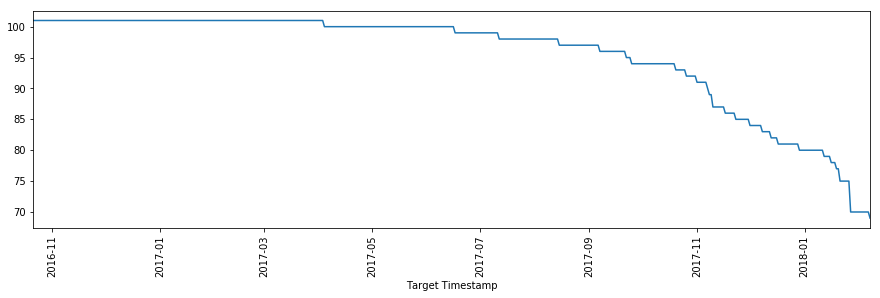

In [432]:
plt.figure(figsize=(15,4))
dataset.groupby('Target Timestamp')['Serial'].count().plot()
plt.xticks(rotation=90)

In [433]:
dataset['Target Timestamp'].nunique()

475

In [434]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45323 entries, 0 to 0
Columns: 604 entries, Serial to CLEANING-1D
dtypes: float64(601), object(3)
memory usage: 209.2+ MB


In [448]:
block = 4
l = int(len(serials)/4)
s_block = []
for n in range(block-1):
    s_block.append(serials[n*l:(n+1)*l])
s_block.append(serials[(n+1)*l:])
    
for n,sl in enumerate(s_block):
    file_name = "Faults_Cleaning_Counters_%d_%s_%d_%d_%02d.csv"%(len(top_serial),time_period,depth,step,n)
    print("Saving ",file_name)
    dataset[dataset['Serial'].isin(sl)].to_csv(file_name)

Saving  Faults_Cleaning_Counters_101_D_20_1_00.csv
Saving  Faults_Cleaning_Counters_101_D_20_1_01.csv
Saving  Faults_Cleaning_Counters_101_D_20_1_02.csv
Saving  Faults_Cleaning_Counters_101_D_20_1_03.csv
